# Setting up

First, we will define some utilities that will be helpful for us.

In [2]:
###############################################################################
# Globals
###############################################################################


import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

# Variables you would like to change :)
card_types = ["clubs", "diamonds", "hearts", "spades"]
card_max_number = 13
card_image_extension = "jpg"
template_path = "../template/"
training_path = "../training/"
query_path = "../query/"

def get_card_name(card_type, card_number):
    return f"{card_type}_{card_number}"


def get_template_card_path(card_name):
    return f"{template_path}{card_name}.{card_image_extension}"


def get_cropped_card_path(card_name):
    return f"{training_path}{card_name}_crop.{card_image_extension}"


def get_features_file_path(card_name):
    return f"{training_path}{card_name}.npz"


def get_query_image_path(file_name):
    return f"{query_path}{file_name}"

cards = [get_card_name(card_type, card_number)
         for card_type in card_types for card_number in range(1, card_max_number + 1)]

## Card parsing & feature extraction

In this block, we iterate over all cards and we get features from them. Output will help you have a brief idea of what's going on: each card is processed in two stages, the first one crops the card, and the second one calculates the features. You will see pairs of X/O in the output. X stands for "stage is happening" and O for "stage has been skipped". Each pair matches a card, so depending on whether the cropped card is already computed or whether the features are already saved in a file for that card, the stage will be processed or skipped. This way we save lots, lots of time :)

In [3]:
###############################################################################
# Card & feature extraction
###############################################################################

sift = cv.SIFT_create()
orb = cv.ORB_create()

card_ratio = 1.416
inverse_card_ratio = 1 / card_ratio
card_min_image_area_percent = 0.02

def get_potential_cards(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh_image = cv.threshold(
        gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    contours, _ = cv.findContours(
        thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    best_card_contours = get_best_card_contours(image, contours)
    while True:
        best_card_contour = next(best_card_contours)
        if best_card_contour is None:
            break
        cv.drawContours(image, best_card_contour[0], -1, (0, 255, 0), 15)
        x, y, w, h = cv.boundingRect(best_card_contour[0])
        yield gray_image[y:y+h, x:x+w]
    yield None


def get_best_card_contours(image, contours):
    (_, image_width, image_height) = image.shape
    image_area = image_width * image_height

    valid_detailed_contours = []
    for contour in contours:
        area = cv.contourArea(contour)
        if area < card_min_image_area_percent * image_area:
            continue
        poly = get_poly_from_contour(contour)
        if len(poly) != 4:
            continue
        valid_detailed_contours.append((contour, area))

    largest_detailed_contours = sorted(valid_detailed_contours, key=lambda detailed_contour: detailed_contour[1], reverse=True)
    for detailed_contour in largest_detailed_contours:
        yield detailed_contour
    yield None


def get_poly_from_contour(contour):
    perimeter = cv.arcLength(contour, True)
    return cv.approxPolyDP(contour, 0.05 * perimeter, True)


def perform_training():
    changed_cards = set()

    if not os.path.exists(training_path):
        os.mkdir(training_path)

    for card_name in cards:
        template_card_path = get_template_card_path(card_name)
        cropped_card_path = get_cropped_card_path(card_name)
        if not os.path.exists(cropped_card_path):
            card_image = cv.imread(template_card_path)
            cropped_card_image = next(get_potential_cards(card_image))
            if cropped_card_image is None:
                print("--", end="")
                continue
            cv.imwrite(cropped_card_path, cropped_card_image)
            changed_cards.add(card_name)
            print("X", end="")
        else:
            print("O", end="")
            cropped_card_image = cv.imread(cropped_card_path)

        features_file_path = get_features_file_path(card_name)
        if not os.path.exists(features_file_path) or card_name in changed_cards:
            print("X", end="")
            _, sift_features = sift.detectAndCompute(
                cropped_card_image, None
            )
            _, orb_features = orb.detectAndCompute(
                cropped_card_image, None
            )
            np.savez_compressed(features_file_path, sift_features=sift_features,
                                orb_features=orb_features)
        else:
            print(f"O", end="")

        print(" | ", end="")


perform_training()


OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | OO | 

# Running detection

First, let's load the features we have calculated before and some utilities we'll need.

In [4]:
###############################################################################
# Running detection - load features stage
###############################################################################

training_features = {
    "sift_features": dict(),
    "orb_features": dict()
}
for card_name in cards:
    with np.load(get_features_file_path(card_name), allow_pickle=True) as raw_features:
        training_features["sift_features"][card_name] = np.copy(
            raw_features["sift_features"])
        training_features["orb_features"][card_name] = np.copy(
            raw_features["orb_features"])

In [5]:
###############################################################################
# Running detection - create matchers
###############################################################################

# Flann matcher for SIFT
FLANN_INDEX_KDTREE = 1
flann_for_sift_index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
flann_for_sift = cv.FlannBasedMatcher(flann_for_sift_index_params, dict())

# Flann matcher for ORB
FLANN_INDEX_LSH = 6
flann_for_orb_index_params = dict(algorithm=FLANN_INDEX_LSH,
                                  table_number=6,
                                  key_size=12,
                                  multi_probe_level=1)
flann_for_orb = cv.FlannBasedMatcher(flann_for_orb_index_params, dict())

# Brute-force matcher for SIFT
bf_for_sift = cv.BFMatcher()

# Brute-force matcher for ORB
bf_for_orb = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)


def pass_good_matches(matches, threshold = 0.7):
    good_matches = []
    for n, m in matches:
        if n.distance < m.distance * threshold:
            good_matches.append([n, m])
    return good_matches

def pass_all_matches(matches):
    return matches


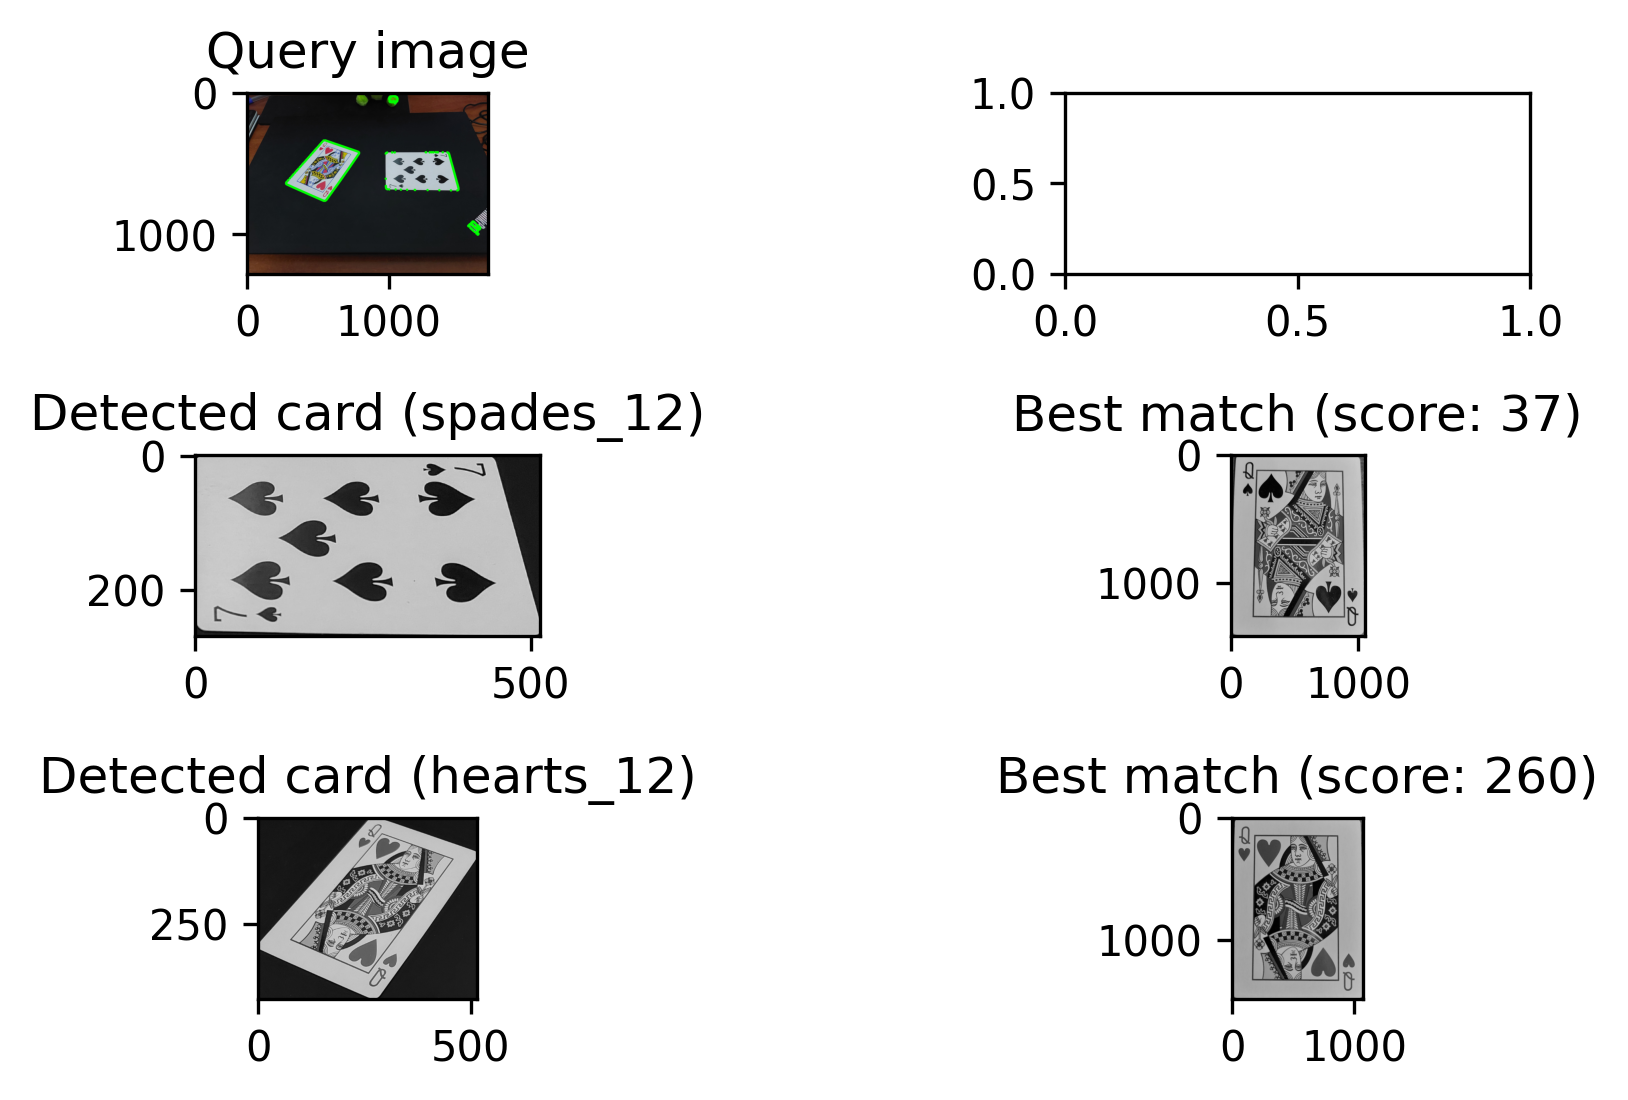

In [6]:
###############################################################################
# Running detection - detecting cards using descriptors!
###############################################################################

def match_cards(query_image, features, feature_extractor, matcher, match_filter=pass_all_matches, match_scorer=len):
    potential_cards = get_potential_cards(query_image)
    while True:
        potential_card = next(potential_cards)
        if potential_card is None:
            break

        _, query_features = feature_extractor(potential_card)
        matches = {
            card_name: match_filter(
                matcher(
                    query_features, features[card_name]
                ),
            ) for card_name in cards
        }
        match_name = max(
            matches, key=lambda entry: match_scorer(matches[entry]))
        match_score = match_scorer(matches[match_name])
        yield (potential_card, match_name, match_score)
    yield None


sift = cv.SIFT_create()
orb = cv.ORB_create()

query_image_path = get_query_image_path("../query/q10.jpg")
query_image = cv.imread(query_image_path)
min_score = 15
failed_attempts = 0
max_failed_attempts = 3
valid_matched_cards = []

matched_cards = match_cards(
    query_image,
    training_features["sift_features"],
    lambda potential_card: sift.detectAndCompute(potential_card, None),
    lambda features1, features2: flann_for_sift.knnMatch(
        features1, features2, k=2),
    lambda matches: pass_good_matches(matches, threshold=0.75)
)

while True:
    matched_card = next(matched_cards)
    if matched_card is None:
        break

    _, _, match_score = matched_card
    if match_score <= min_score:
        failed_attempts += 1
        if failed_attempts >= max_failed_attempts:
            break
    else:
        valid_matched_cards.append(matched_card)


valid_matched_cards_images = [cv.imread(get_cropped_card_path(
    card_name)) for _, card_name, _ in valid_matched_cards]

figure, axes = plt.subplots(len(valid_matched_cards) + 1, 2)
figure.set_dpi(300)
plt.title("Results")
axes[0][0].set_title("Query image")
axes[0][0].imshow(cv.cvtColor(query_image, cv.COLOR_BGR2RGB))
for i, (card_image, card_name, match_score) in enumerate(valid_matched_cards):
    axes[i + 1][0].set_title(f"Detected card ({card_name})")
    axes[i + 1][0].imshow(cv.cvtColor(card_image, cv.COLOR_GRAY2RGB))
    axes[i + 1][1].set_title(f"Best match (score: {match_score})")
    axes[i + 1][1].imshow(valid_matched_cards_images[i])

plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


In [7]:
#---------------- useless --------------------------------
import math
CARD_RATIO = 1.416


def get_vertices_from_poly(poly):
    return [raw_vertex[0] for raw_vertex in poly]

def get_best_card_contour(contours):
    largest_contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]

    for i, contour in enumerate(largest_contours):
        vertices = get_vertices_from_poly(get_poly_from_contour(contour))
        if len(vertices) == 4:
            print(str(i) + ":" + str(vertices))

    return largest_contours[1]
    # return min(largest_contours, key=compute_card_contour_score)


def compute_card_contour_score(contour):
    vertices = get_vertices_from_poly(get_poly_from_contour(contour))
    ang11 = ang([vertices[0], vertices[1]], [vertices[0], vertices[3]])
    ang12 = ang([vertices[3], vertices[2]], [vertices[3], vertices[0]])
    ang21 = ang([vertices[1], vertices[0]], [vertices[1], vertices[2]])
    ang22 = ang([vertices[2], vertices[1]], [vertices[2], vertices[3]])
    sum_angles_1 = ang11 + ang21
    sum_angles_2 = ang21 + ang12
    print(sum_angles_1, sum_angles_2)
    dif_angles = 180.0 - sum_angles_1 + 180.0 - sum_angles_2
    return dif_angles


def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]


def ang(lineA, lineB):
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    dot_prod = dot(vA, vB)
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    angle = math.acos(dot_prod/magB/magA)
    ang_deg = math.degrees(angle) % 360
    if ang_deg-180 >= 0:
        return 360 - ang_deg
    else:
        return ang_deg